# Micrograd
Building a pytorch inspired computation graph framework for automatic differentiation over a DAG.
This is a step-by step imlpementation for backpropogation and training neural networks.

In [1]:
# %conda install python-graphviz

In [2]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The class **`Value`** is the fundamental datastructure for constructing the computational graph. It keeps track of the data, gradient of the node and operations involved in making the node, forming a graph. The class supports basic arthimetic operations like addition, multiplication, exponentiation and more.<br><br>
The `backward` function is crucial for computing gradients during the backpropagation process. It initiates a reverse topological traversal of the computation graph, starting from the current instance of Value. During this traversal, it calls the `_backward` method for each node in the graph, allowing each node to compute and accumulate its gradient with respect to the output.

In [3]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.label=label
        self.grad=0.0
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __neg__(self):
        return self *-1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad = other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other):
        return self*other**-1
    
    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    # reverse topological traversal to compute gradients wrt outpu
    def backward(self):  
        visited = set()
        topo = []
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        

In [4]:
# building visualization for the computational graph
import os
os.environ["PATH"] += os.pathsep + 'C:/users/aditisingh/miniconda3/envs/py310/lib/site-packages/'

from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
    

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, shape='record', label="{ %s | data %.4f | grad %.4f}"%(n.label, n.data, n.grad))
        if n._op:
            dot.node(name = uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

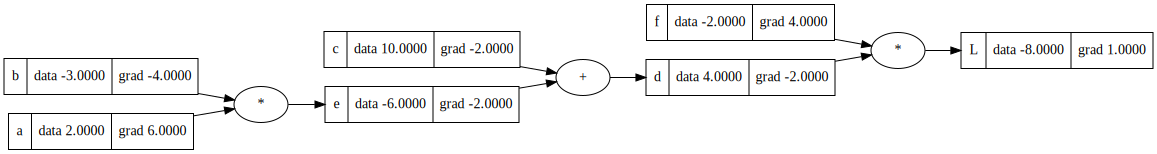

In [16]:
# example
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
  
L.grad = 1
L.backward()

draw_dot(L)

## Understanding Gradients

### 1. Killing the gradients

**Vanishing Gradient Problem** : The `tanh` function squashes the input in the range (-1, 1). When the input to tanh is very large or very small the derivate of tanh becomes close to zero. This causes vanishing gradient problem during back propogation. If the gradient is very small, then the weights will be updated by a very small amount or not be updated at all, which can lead to slow or halted learning in corresponding neurons.<br>
**Solution** : Using an alternative activation function like ReLU (Rectified Linear Unit) or Leaky ReLU

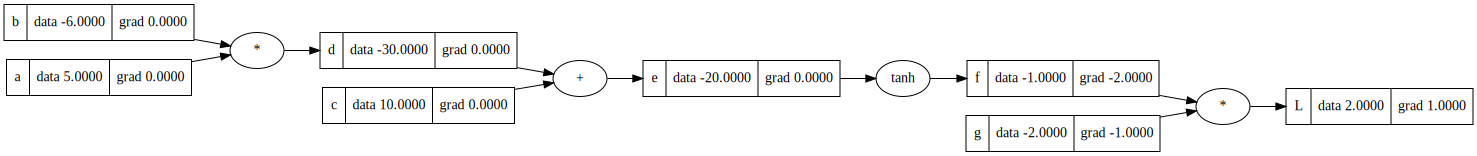

In [6]:
a = Value(5.0, label='a')
b = Value(-6, label='b')
c = Value(10, label='c')
d = a*b; d.label='d'
e = d+c; e.label='e'
f = e.tanh(); f.label='f'
g = Value(-2, label='g')
L = f*g; L.label='L'
6 + (-L)**3

L.grad = 1
L.backward()

draw_dot(L)

### 2. Addition
Addition operation distributes the gradients equally to the parent node in a backward propogation.

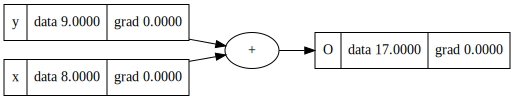

In [7]:
x = Value(8, label='x')
y = Value(9, label='y')
o = x+y; o.label='O'
draw_dot(o)

In [8]:
o.grad = 1
x.grad = 1 # d(x+y)/dx = 1
y.grad = 1 # d(x+y)/dy = 1

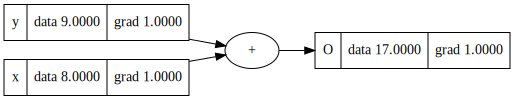

In [9]:
draw_dot(o)

### 3. Multiplation
Multiplication operation distributes the gradients proportional to the value of operands in backward propogation.

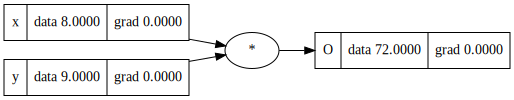

In [10]:
x = Value(8, label='x')
y = Value(9, label='y')
o = x*y; o.label='O'
draw_dot(o)

In [11]:
o.grad = 1
x.grad = 9 # dxy/dx = y
y.grad = 8 # dxy/dy = x

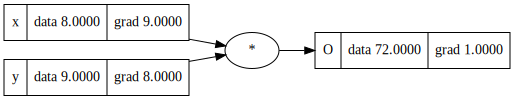

In [12]:
draw_dot(o)

### 3. compound function
To calculate the gradients of compound functions we apply the chain rule.

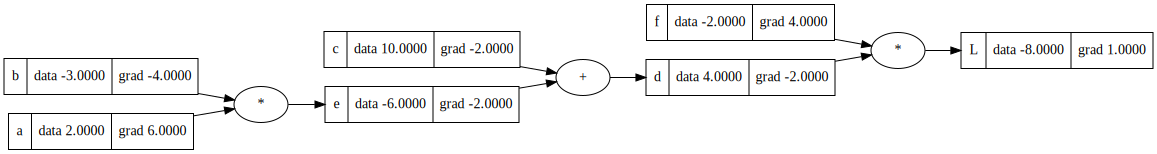

In [17]:
draw_dot(L)

In [14]:
L.grad = 1
# g._backward()
# f._backward()
L.backward()

In [18]:
L.grad = 1
f.grad = 4 # dL/df
e.grad = -2 # dL/de 
d.grad = -2 # dL/dd 
c.grad = -2 # dL/dc  
b.grad = -4 # dL/db  
a.grad = 6# dL/da

In [19]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

Gradients over a single operation are to be added.

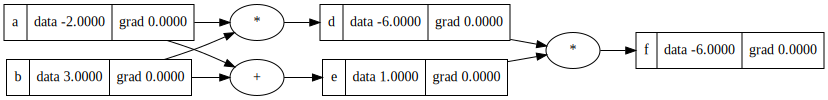

In [20]:
draw_dot(f)

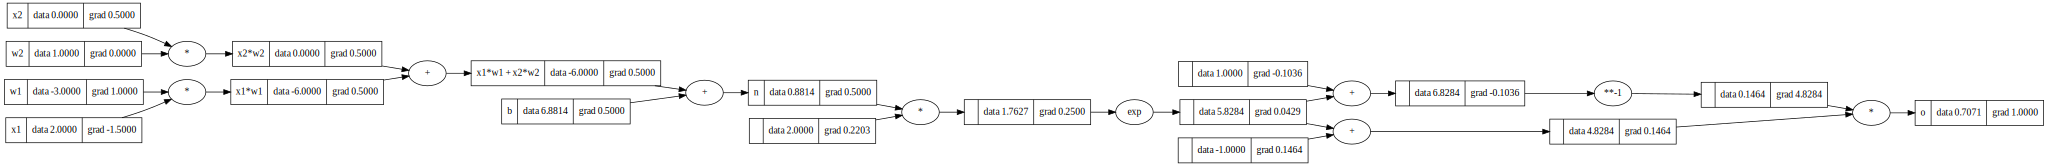

In [21]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

## Building Neural Network
To build a complete neural network we have the following classes:
- Neuron : Single unit of a Neural Network
- Layers : Collection of Neurons
- MlP : Collection of Layers

The **Neuron class** encapsulates the design and functionality of a single neuron, in a neural network, including intialization with random weights and bias, computation of weighted sum followed by activation function.
<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*T4ARzySpEQvEnr_9pc78pg.jpeg" width="600">


In [22]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1), label=f'w{i}') for i in range (nin)]
        self.b = Value(random.uniform(-1, 1), label='b')
        
    def __call__(self, x):
        # sums(w*x) + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

In [23]:
x = [2.0, 3.0]
n = Neuron(3)
n(x), n.parameters

(Value(data=-0.6064106645893768),
 <bound method Neuron.parameters of <__main__.Neuron object at 0x00000142BE3B4AF0>>)

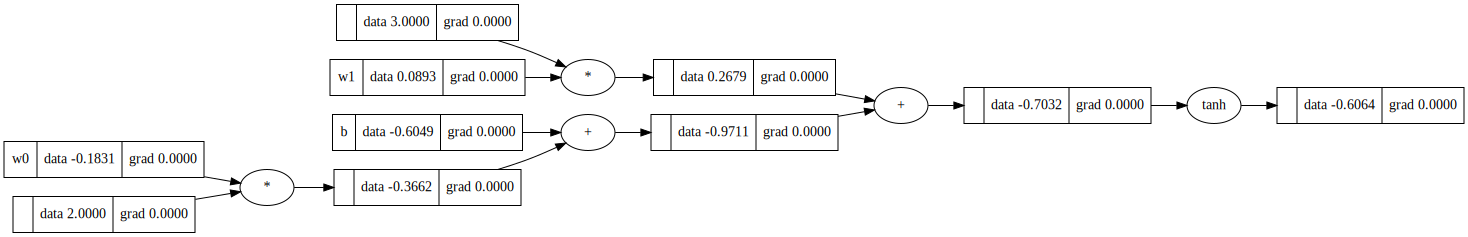

In [24]:
draw_dot(n(x))

This class **Layer**, represents a layer in a neural network, consisting of multiple neurons. It provides methods to compute the layer's output given an input, and to retrieve all the parameters (weights and biases) of the neurons in the layer. 

In [25]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) ==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [26]:
x = [2, 3]
n = Layer(2, 3)
n(x)

[Value(data=0.7879843736477389),
 Value(data=0.8424657971053489),
 Value(data=0.99491142580671)]

**MLP class** encapsulates the structure of a simple feedforward neural network with multiple layers. It provides methods to compute the network's output given an input and to retrieve all the parameters of the network for tasks such as training and optimization.


In [28]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts # nout is list of neurons in each layer, so we get the size of network
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] # number of output neurons for each layer is input for next
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [33]:
x = [2, 3, 5]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.13618573647038942)

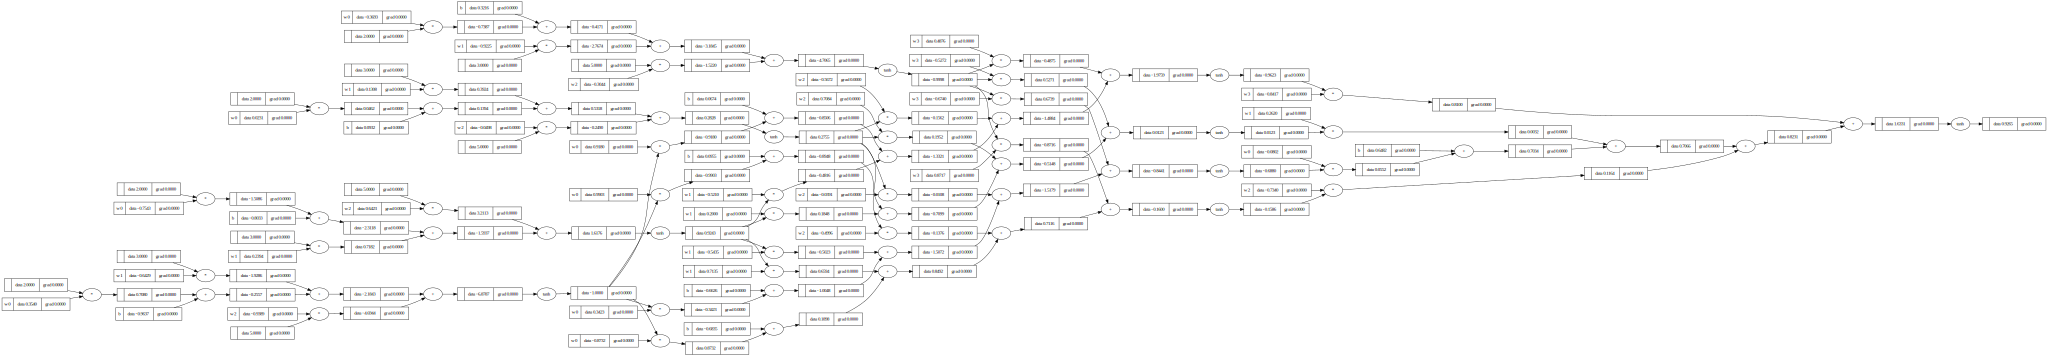

In [30]:
draw_dot(n(x))

### Training a complete Neural Network

In [34]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs] # n = MLP(3, [4, 4, 1])
ypred

[Value(data=-0.3721991325820813),
 Value(data=0.47562300947447),
 Value(data=-0.09445724508272939),
 Value(data=-0.25060425704740674)]

In [348]:
loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))
loss

Value(data=4.096777016343986)

In [350]:
# Optimizing the network

epochs = 10

for k in range(epochs):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))
    
    # backward pass
    # intializate grads -after the data has been updated, the grads chg - and we should flush oout the old ones
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update parameters
    for p in n.parameters():
        p.data += -0.1*p.grad
        
    print(k, loss.data)

0 15.827557120949558
1 15.800504808209553
2 15.764573402874946
3 15.714867228556244
4 15.64228677795802
5 15.52796791200401
6 15.325586308032953
7 14.87386388428503
8 12.243389019275826
9 7.079665517342194


In [351]:
ypred

[Value(data=0.9449358580151824),
 Value(data=0.854829864785293),
 Value(data=0.9060296259797831),
 Value(data=0.9426354186138343)]

In [352]:
n.parameters()

[Value(data=0.12500297835893098),
 Value(data=-0.7833432780001683),
 Value(data=0.8542472174291917),
 Value(data=0.33250695464092994),
 Value(data=-0.8056058090985406),
 Value(data=-0.4939492785976415),
 Value(data=0.9341071035340963),
 Value(data=-0.9985788621236621),
 Value(data=0.5737176998075297),
 Value(data=-0.6771318904728899),
 Value(data=-0.07326670721908812),
 Value(data=-0.7308572151521047),
 Value(data=1.3500903525506593),
 Value(data=0.6565529509609109),
 Value(data=0.15044594126330588),
 Value(data=1.4742137962390158),
 Value(data=0.6112236001240378),
 Value(data=-1.2361570669282216),
 Value(data=-0.3025275524394602),
 Value(data=1.4043452411599864),
 Value(data=0.0525657526498036),
 Value(data=0.5864391397742775),
 Value(data=-0.22219775275965),
 Value(data=0.1377074182545619),
 Value(data=-0.3910608443305322),
 Value(data=-0.5530313571812562),
 Value(data=0.8060111455222491),
 Value(data=-0.14635189779619032),
 Value(data=0.056725733561521635),
 Value(data=0.51948244044